# Image Segmentation using U-Net Architecture

### **Loading Kaggle Data to Google Colab**

To import the data from Kaggle to Google Colab, following is the [easiest method](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kumaresanmanickavelu/lyft-udacity-challenge

! mv /content/lyft-udacity-challenge.zip /content/gdrive/MyDrive/Projects
! unzip /content/gdrive/MyDrive/Projects/lyft-udacity-challenge.zip

### **Importing Required Libraries**

In [ ]:
! pip install matplotlib==3.3.2

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model

### **Creating the U-Net Model**

In [2]:
TRAIN_IMAGE_PATH = r"data/train/images/"
TRAIN_ANNOTATION_PATH = r"data/train/annotations/"

TEST_IMAGE_PATH = r"data/test/"

IP_IMG_SIZE = (600, 800)

normalize_image = True
NUM_CLASSES = 13
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 30

In [ ]:
class ConvBlockC(tf.keras.layers.Layer):
    def __init__(self, n_filters, layer_number, name=None, filter_size=3, batch_norm=False):
        super().__init__(name=name)
        self.n_filters = n_filters
        self.layer_number = layer_number
        self.filter_size = filter_size
        self.batch_norm = batch_norm
        
    def __call__(self, input_tensor, training=True):
        x = Conv2D(filters=self.n_filters, kernel_size=(self.filter_size, self.filter_size),
                   kernel_initializer='he_normal', padding='same', name="Layer"+self.layer_number+"_Conv1")(input_tensor)
        if self.batch_norm:
            x = BatchNormalization()(x, training=training)
        x = Activation('relu', name="Layer"+self.layer_number+"_ReLU1")(x)
        
        x = Conv2D(filters=self.n_filters, kernel_size=(self.filter_size, self.filter_size),
                   kernel_initializer='he_normal', padding='same', name="Layer"+self.layer_number+"_Conv2")(x)
        if self.batch_norm:
            x = BatchNormalization()(x, training=training)
        x = Activation('relu', name="Layer"+self.layer_number+"_ReLU2")(x)
        return x


def UNET(input_shape, n_classes, batch_norm=False, batch_norm_training=True):
    input_layer = Input(shape=input_shape)
    filters = [16, 32, 64, 128]
    skip_connections = []
    
    # Encoder
    x = input_layer
    for i, n_filter in enumerate(filters):
        x = ConvBlockC(n_filters=n_filter, batch_norm=batch_norm, layer_number=str(i))(x, training=batch_norm_training)
        skip_connections.append(x)
        x = MaxPool2D((2, 2), strides=2)(x)
    
    # Bridge
    x = ConvBlockC(n_filters=filters[-1]*2, batch_norm=batch_norm, layer_number=str(i+1))(x, training=batch_norm_training)
    
    # Decoder
    layer_num = i+2
    for i in range(len(filters)-1, -1, -1):
        x = Conv2DTranspose(filters=filters[i], kernel_size=3, strides=2, padding='same')(x)
        x = Concatenate(axis=-1)([x, skip_connections[i]])
        x = ConvBlockC(n_filters=filters[i], batch_norm=batch_norm, layer_number=str(layer_num))(x, training=batch_norm_training)
        layer_num += 1
    
    output = Conv2D(filters=n_classes, kernel_size=3, padding='same', activation='softmax')(x)
    return Model(inputs=input_layer, outputs=output)

### **Pre-processing and Loading Training Data using tf.data.Dataset**

In [ ]:
def load_train_data(image):
    img_file = tf.io.read_file(image)
    img_file = tf.image.decode_png(img_file, dtype=tf.uint8)
    img_file = tf.image.resize(img_file, (IMG_SIZE, IMG_SIZE))
    if normalize_image:
        img_file = tf.cast(img_file, tf.float32) / 255.0
    
    mask_path = tf.strings.regex_replace(image, "CameraRGB", "CameraSeg")
    mask_file = tf.io.read_file(mask_path)
    mask_file = tf.image.decode_png(mask_file, dtype=tf.uint8)
    mask_file = tf.image.resize(mask_file, (IMG_SIZE, IMG_SIZE), method='nearest')
    mask_file = tf.squeeze(tf.slice(mask_file, [0, 0, 0], [IMG_SIZE, IMG_SIZE, 1]))
    mask_file = tf.one_hot(mask_file, depth=NUM_CLASSES)
    
    return img_file, mask_file


training_images_path = os.listdir(TRAIN_IMAGE_PATH)

train_data = tf.data.Dataset.list_files(TRAIN_IMAGE_PATH+"*.png")
train_data = train_data.map(load_train_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_data.batch(BATCH_SIZE)

### **Compiling and Training Model**

In [ ]:
model = UNET((IMG_SIZE, IMG_SIZE, 3), n_classes=NUM_CLASSES, batch_norm=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='acc')

callback = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/Projects/unet_128_30e.h5", monitor='loss', save_best_only=True)
history = model.fit(train_data, epochs=EPOCHS, verbose=1, callbacks=callback)

# model.save("/content/gdrive/MyDrive/Projects/unet_128_30e.h5")

### **Visualizing the Output of trained model**

In [3]:
%matplotlib inline

BLACK = [0, 0, 0]
FENCE = [255, 255, 0]
ROAD = [0, 255, 0]
VEHICLE = [0, 0, 255]
LANE_MARK = [255, 0, 0]
FOOT_PATH = [0, 255, 255]
TREES = [0, 140, 255]
BUILDING = [140, 0, 255]

# {'bldg': 1, 'fence': 2, 'lane mark': 6, 'road': 7, 'footpath': 8, 'trees': 9, 'vehicle': 10}
transdict = [BLACK, BLACK, BLACK, BLACK, BLACK, BLACK, BLACK, ROAD, BLACK, BLACK, BLACK, BLACK, BLACK, BLACK]

unet_model = load_model("unet256_30e.h5")

def load_image(name: str):
    img_file = tf.io.read_file(TEST_IMAGE_PATH + name)
    img_file = tf.image.decode_png(img_file, dtype=tf.uint8)
    img_file = tf.image.resize(img_file, (IMG_SIZE, IMG_SIZE))
    if normalize_image:
        img_file = tf.cast(img_file, tf.float32) / 255.0
    img_file = tf.expand_dims(img_file, axis=0)
    return img_file

def display_prediction(pred, image_name, resize_output=False, overlay=False):
    pred = tf.expand_dims(tf.squeeze(tf.argmax(pred, axis=-1)), axis=-1).numpy().astype(np.uint8)
    if overlay:
        og_image = cv2.imread(TEST_IMAGE_PATH+image_name)
        b, g, r = cv2.split(og_image)
        og_image = cv2.merge((r, g, b))
        og_image = cv2.resize(og_image, (IMG_SIZE, IMG_SIZE))
        pred = cv2.merge((pred, pred, pred))
        for i in range(pred.shape[0]):
            for j in range(pred.shape[1]):
                x = transdict[pred[i][j][0]]
                pred[i][j] = x if x != [0, 0, 0] else og_image[i][j]
        pred = cv2.addWeighted(og_image, 0.7, pred, 0.3, 0)
    if resize_output:
        pred = cv2.resize(pred, tuple(reversed(IP_IMG_SIZE)))
    plt.figure(figsize=(8, 8))
    plt.imshow(pred)
    plt.axis('off')
    plt.show()

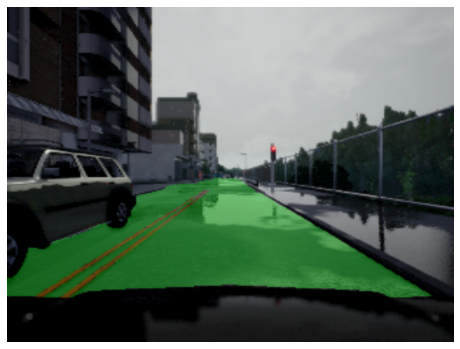

In [4]:
img_name = "02_00_002.png"

prediction = unet_model.predict(load_image(img_name))
display_prediction(prediction, img_name, resize_output=True, overlay=True)